# Carga de librerias

In [60]:
import warnings

import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from ultralytics import YOLO
from util import *

warnings.simplefilter("ignore")

# Variables

In [61]:
# Diccionario de etiquetas de colores
color_labels = {
    "Negro": (0, 0, 0),
    "Blanco": (255, 255, 255),
    "Gris": (128, 128, 128),
    "Plata": (192, 192, 192),
    "Azul": (0, 0, 255),
    "Rojo": (255, 0, 0),
    "Verde": (0, 128, 0),
    "Amarillo": (255, 255, 0),
    "Naranja": (255, 165, 0),
    "Marrón": (139, 69, 19),
    "Beige": (245, 245, 220),
    "Vino": (128, 0, 0),
    "Azul marino": (0, 0, 128),
    "Dorado": (255, 215, 0),
    "Bronce": (205, 127, 50),
    "Champán": (247, 231, 206),
    "Cobre": (184, 115, 51),
    "Esmeralda": (80, 200, 120),
    "Turquesa": (64, 224, 208),
    "Azul cielo": (135, 206, 235),
    "Lila": (200, 162, 200),
    "Lavanda": (230, 230, 250),
    "Rosa": (255, 192, 203),
    "Rosa mexicano": (255, 0, 127),
    "Morado": (128, 0, 128),
    "Grafito": (54, 69, 79),
    "Carbón": (70, 70, 70),
    "Azul rey": (65, 105, 225),
    "Verde oliva": (107, 142, 35),
    "Verde militar": (85, 107, 47),
    "Verde limón": (173, 255, 47),
    "Verde bosque": (34, 139, 34),
    "Verde menta": (152, 255, 152),
    "Celeste": (173, 216, 230),
    "Azul petróleo": (0, 102, 153),
    "Azul zafiro": (15, 82, 186),
    "Amarillo mostaza": (255, 219, 88),
    "Amarillo pastel": (250, 250, 210),
    "Naranja quemado": (255, 140, 0),
    "Rojo cereza": (222, 49, 99),
    "Rojo óxido": (165, 42, 42),
    "Rojo escarlata": (255, 36, 0),
    "Borgoña": (128, 0, 32),
    "Marrón chocolate": (123, 63, 0),
    "Café oscuro": (101, 67, 33),
    "Crema": (255, 253, 208),
    "Marfil": (255, 255, 240),
    "Peltre": (110, 104, 94),
    "Almendra": (239, 222, 205),
    "Caqui": (195, 176, 145),
    "Arena": (210, 180, 140),
    "Azul hielo": (173, 216, 230),
    "Perla": (234, 224, 200),
    "Gris ceniza": (176, 176, 176),
    "Gris oscuro": (105, 105, 105),
    "Gris perla": (200, 200, 200),
}

vehicle_labels = {"car": "Automovil", "motorcycle": "Motocicleta", "bus": "Autobus", "truck": "Camion"}

# Modelo

In [64]:
class LicencePlateProcessor:
    def __init__(
        self,
        model_vechicle_detection="yolov8l.pt",
        model_plate_recognition="license_plate_detector.pt",
        ocr_langs=["en"],
        use_gpu=True,
        color_labels=color_labels,
        vechicle_labels=vehicle_labels,
        min_size_text=20,
        k_clusters_colors=3,
    ):
        self.device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
        self.model_vechicle_detection = YOLO(model_vechicle_detection)
        self.model_plate_recognition = YOLO(model_plate_recognition)
        self.reader = easyocr.Reader(ocr_langs, gpu=(self.device == "cuda"))
        self.color_labels = color_labels
        self.vehicle_labels = vechicle_labels
        self.min_size_text = min_size_text
        self.k_clusters_color = k_clusters_colors
        print(f"Usando dispositivo {self.device.upper()}")

    def detect_objects(self, image):
        return self.model_vechicle_detection(image)

    def extract_text(self, crop_image):
        ocr_result = self.reader.readtext(crop_image, min_size=self.min_size_text)
        plate_text = "No detectada" if len(ocr_result) == 0 else ocr_result[0][-2]
        score_text_detected = (
            "No detectada" if len(ocr_result) == 0 else ocr_result[0][-1]
        )
        return plate_text.upper(), score_text_detected

    def detect_color(self, image):
        color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(color_image, (100, 100))
        reshape_image = resized_image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=self.k_clusters_color)
        kmeans.fit(reshape_image)
        predominant_color = kmeans.cluster_centers_[kmeans.labels_[0]].astype(int)
        min_dist = float("inf")
        detected_color = "No detectado"
        for color, rgb in color_labels.items():
            dist = np.linalg.norm(predominant_color - np.array(rgb))
            if dist < min_dist:
                min_dist = dist
                detected_color = color
        return detected_color

    def show_image(self, image):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.show()

    def detect_plate(self, image_crop):
        detections = self.model_plate_recognition(image_crop)
        area_biggest_box = 0
        x1_det, x2_det = 0, image_crop.shape[0]
        y1_det, y2_det = 0, image_crop.shape[1]
        text_plate = "No detectada"
        for object in detections:
            for box in object.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                area = (x2 - x1) * (y2 - y1)
                if area > area_biggest_box:
                    crop = image_crop[y1:y2, x1:x2]
                    text_plate, _ = self.extract_text(crop)
                    x1_det, x2_det = x1, x2
                    y1_det, y2_det = y1, y2
        cv2.rectangle(image_crop, (x1_det, y1_det), (x2_det, y2_det), (0, 255, 0), 2)
        image_plate = image_crop[y1_det:y2_det, x1_det:x2_det]
        return text_plate, image_plate

    def process_image(self, image_path):
        image = cv2.imread(image_path)
        detections = self.detect_objects(image)
        area_biggest_vehicle_box = 1000
        x1_biggest, x2_biggest = 0, image.shape[0]
        y1_biggest, y2_biggest = 0, image.shape[1]
        color_biggest_vehicle_box = "No detectado"
        text_plate_biggest_vechicle_box = "No detectada"
        cls_biggest_vechicle_box = "No detectado"
        image_plate = []
        for object in detections:
            for box in object.boxes:
                cls_object = int(box.cls[0].item())
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                area = (x2 - x1) * (y2 - y1)
                if area > area_biggest_vehicle_box:
                    print(area)
                    crop = image[y1:y2, x1:x2]
                    if cls_object in [2, 3, 5, 7]:
                        plate_text, image_plate = self.detect_plate(crop)
                        # plate_text, _ = self.extract_text(crop)
                        detected_color = self.detect_color(image)
                        cls_vehicle = self.model_vechicle_detection.names.get(
                            cls_object
                        )
                        cls_vehicle = self.vehicle_labels.get(cls_vehicle)
                        x1_biggest, y1_biggest, x2_biggest, y2_biggest = x1, y1, x2, y2
                        area_biggest_vehicle_box = area
                        text_plate_biggest_vechicle_box = plate_text
                        color_biggest_vehicle_box = detected_color
                        cls_biggest_vechicle_box = cls_vehicle
        cv2.rectangle(
            image, (x1_biggest, y1_biggest), (x2_biggest, y2_biggest), (0, 255, 0), 2
        )
        cv2.putText(
            image,
            f"Vehiculo: {cls_biggest_vechicle_box}",
            (x1_biggest, y1_biggest + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 255, 255),
            2,
        )
        self.show_image(image)
        if len(image_plate)>0:
            self.show_image(image_plate)
        return (
            text_plate_biggest_vechicle_box,
            color_biggest_vehicle_box,
            cls_biggest_vechicle_box,
        )

Using CPU. Note: This module is much faster with a GPU.


Usando dispositivo CPU

0: 512x640 1 person, 1 car, 1 dog, 546.4ms
Speed: 3.4ms preprocess, 546.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
76162
80013


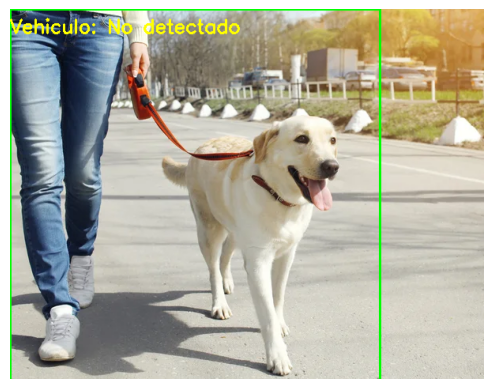

Placa : No detectada
Color : No detectado
Tipo : No detectado


In [72]:
ruta = r"CochesVarios_png/perrito2.png" 

precessor = LicencePlateProcessor()
text_plate, detected_color, cls_vehicle = precessor.process_image(ruta)
print(f"Placa : {text_plate}")
print(f"Color : {detected_color}")
print(f"Tipo : {cls_vehicle}")